# Predictions of Loans

## Goal:

Automate the **loan eligibility process** based on customer detail provided while filling online application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and others.

We will estimate the performance of different models, in particular:

- **Random Forest**
- **Gradient Boosting**
- **Logistic Regression**
- **Naive Bayes**

## Data

We have a table that contains information about loan's applicants.

**Columns:**


- **Loan_ID**: Unique Loan ID
- **Gender:** Male/ Female
- **Married:** Applicant married (Y/N)
- **Dependents:** Number of dependents
- **Education:** Applicant Education (Graduate/ Under Graduate)
- **Self_Employed:** Self employed (Y/N)
- **ApplicantIncome:** Applicant income per month in \$
- **CoapplicantIncome:** Coapplicant income
- **LoanAmount:** Loan amount in thousands \$
- ** Loan_Amount_Term:** Term of loan in months
- **Credit_History:** Credit history meets guidelines
- **Property_Area:** Urban/ Semi Urban/ Rural
- **Loan_Status:** Loan approved (Y/N) *This is our label*

### Import dependencies

In [1]:
# Import main libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
# Import Classifiers 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, partial_dependence
from sklearn.ensemble.partial_dependence import plot_partial_dependence

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [3]:
# Import Model Evaluation tools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV, learning_curve

In [4]:
# Import Metrics
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

### Read in the data¶

In [5]:
url = 'https://bitbucket.org/fukac99/onlinebasecamp/raw/e6f5ba811195e7fc4acca0c0e7aa56db181b0600/classification_exercise.csv'

In [6]:
df =pd.read_csv(url)

# Check first 5 rows of the dataframe to get a sense of the data
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


### Explore the dataset

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
Loan_ID              614 non-null object
Gender               601 non-null object
Married              611 non-null object
Dependents           599 non-null object
Education            614 non-null object
Self_Employed        582 non-null object
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
LoanAmount           592 non-null float64
Loan_Amount_Term     600 non-null float64
Credit_History       564 non-null float64
Property_Area        614 non-null object
Loan_Status          614 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 62.4+ KB


In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ApplicantIncome,614.0,5403.459283,6109.041673,150.0,2877.5,3812.5,5795.00,81000.0
CoapplicantIncome,614.0,1621.245798,2926.248369,0.0,0.0,1188.5,2297.25,41667.0
LoanAmount,592.0,146.412162,85.587325,9.0,100.0,128.0,168.00,700.0
Loan_Amount_Term,600.0,342.000000,65.120410,12.0,360.0,360.0,360.00,480.0
Credit_History,564.0,0.842199,0.364878,0.0,1.0,1.0,1.00,1.0


In [9]:
df.describe(include='O')

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
count,614,601,611,599,614,582,614,614
unique,614,2,2,4,2,2,3,2
top,LP002314,Male,Yes,0,Graduate,No,Semiurban,Y
freq,1,489,398,345,480,500,233,422


In [10]:
df.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [11]:
# check for duplicates
df.duplicated().sum()

0

In [12]:
# check for unique ID
df.Loan_ID.nunique()== df.shape[0]

True

A few quick observations:
- there are some missing values that must be dealt with during data cleaning phase
- for a consistent numbers of applicants no credit history is available
- there are no duplicates of any kind into the dataset
- the dtypes appear consistent with what expected, apart from Dependents which is an *object* instead of an *int* type
- the label of the challenge is a categorical one (Y/N) and be better transformed in a numerical one to allow data analysis 

### Data Cleaning

In [13]:
# print unique values of each column to gain high level perspective of the data
for col_name in df.columns:
        unique_cat = len(df[col_name].unique())
        print("Feature '{}' has {} unique categories".format(col_name, unique_cat))
        print("They are:", df[col_name].unique(), '\n' )

Feature 'Loan_ID' has 614 unique categories
They are: ['LP001002' 'LP001003' 'LP001005' 'LP001006' 'LP001008' 'LP001011'
 'LP001013' 'LP001014' 'LP001018' 'LP001020' 'LP001024' 'LP001027'
 'LP001028' 'LP001029' 'LP001030' 'LP001032' 'LP001034' 'LP001036'
 'LP001038' 'LP001041' 'LP001043' 'LP001046' 'LP001047' 'LP001050'
 'LP001052' 'LP001066' 'LP001068' 'LP001073' 'LP001086' 'LP001087'
 'LP001091' 'LP001095' 'LP001097' 'LP001098' 'LP001100' 'LP001106'
 'LP001109' 'LP001112' 'LP001114' 'LP001116' 'LP001119' 'LP001120'
 'LP001123' 'LP001131' 'LP001136' 'LP001137' 'LP001138' 'LP001144'
 'LP001146' 'LP001151' 'LP001155' 'LP001157' 'LP001164' 'LP001179'
 'LP001186' 'LP001194' 'LP001195' 'LP001197' 'LP001198' 'LP001199'
 'LP001205' 'LP001206' 'LP001207' 'LP001213' 'LP001222' 'LP001225'
 'LP001228' 'LP001233' 'LP001238' 'LP001241' 'LP001243' 'LP001245'
 'LP001248' 'LP001250' 'LP001253' 'LP001255' 'LP001256' 'LP001259'
 'LP001263' 'LP001264' 'LP001265' 'LP001266' 'LP001267' 'LP001273'
 'LP0012

In [14]:
# We now know that dependents contains a '3+' value, that might as well be changed to 3 to avoid problems later on
df['Dependents'] = df['Dependents'].replace('3+', 3)

In [15]:
#np.sort(df.ApplicantIncome.unique())

In [16]:
# The type is a float but it appears no reason to keep it like that, let's cast it as an integer
df['CoapplicantIncome'] = df.CoapplicantIncome.astype('int')

In [17]:
#np.sort(df.CoapplicantIncome.unique())

In [18]:
#np.sort(df.LoanAmount.unique())

The range of the values appears reasonable. So we keep in going with some exploratory data analysis

### EDA (Exploratory Data Analysis)

###### Examine label distribution (Loan Status)

In [19]:
# Let's map label variable from Y/N to 0/1 (Loan request rejected/Accepted)
df['Loan_Status'] = np.where(df['Loan_Status']=='Y', 1, 0)

In [20]:
df.Loan_Status.value_counts(normalize=True)*100

1    68.729642
0    31.270358
Name: Loan_Status, dtype: float64

The dataset is not skewed. In fact some 2/3rd of the loan request have been accepted. 

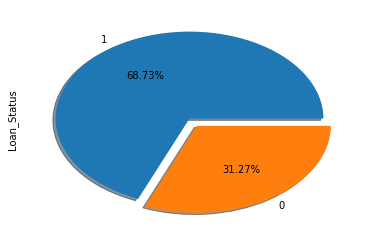

In [21]:
#Visualization in a pie chart of the label
df['Loan_Status'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.2f%%', shadow=True);

###### Univariate Analysis of the label

Let's define some functions to automate the process of generating diagrams

In [22]:
# to generate bar charts
def makebarchart(df, column, label):
    f, ax = plt.subplots(1,2, figsize=(18,6))
    sns.countplot(column, data=df, ax=ax[0])
    ax[0].set_title(column + ' Userbase Distribution')
    (df.groupby(column)[label].mean()*100).plot.bar(ax=ax[1], color=['firebrick','forestgreen', 'darkblue'])
    ax[1].set_title('Loan Accepted by ' + column);
    ax[1].set_yticks(np.arange(10,110,10))
    ax[1].set_ylabel('Percentage (%)')
    ax[1].axis('tight')
    sns.despine(left=True)

In [23]:
# to generate histograms
def makehistchart(df, column, label, bins):
    bins=bins # set the number of bins
    f,ax=plt.subplots(1,2,figsize=(18,6))
    df[df[label]==0][column].plot.hist(bins=bins, color='r', edgecolor='black', ax=ax[0])
    ax[0].set_title('Loan Rejected') # frequencies of label= 0
    df[df[label]==1][column].plot.hist(bins=bins, color='g', edgecolor='black', ax=ax[1])
    ax[1].set_title('Loan Accepted') # frequencies of label = 1
    
    # overlap the two diagram for a better visualization
    f =plt.figure(figsize=(18,6))
    plt.hist(df[df[label]==1][column], bins=bins, color='g', edgecolor='black', label='Loan Accepted')
    plt.hist(df[df[label]==0][column], bins=bins, color='r', edgecolor='black', label='Loan Rejected', alpha=0.8)
    plt.title(column + ' Distribution overlapping by ' + label)
    plt.ylabel('Frequency'); plt.xlabel(label)
    plt.legend(loc='upper center', frameon=False, ncol=2);

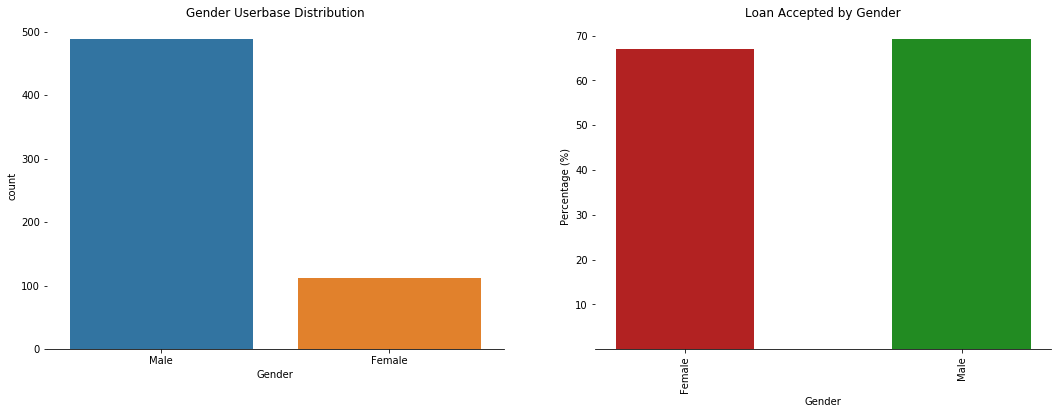

In [24]:
makebarchart(df, 'Gender', 'Loan_Status')

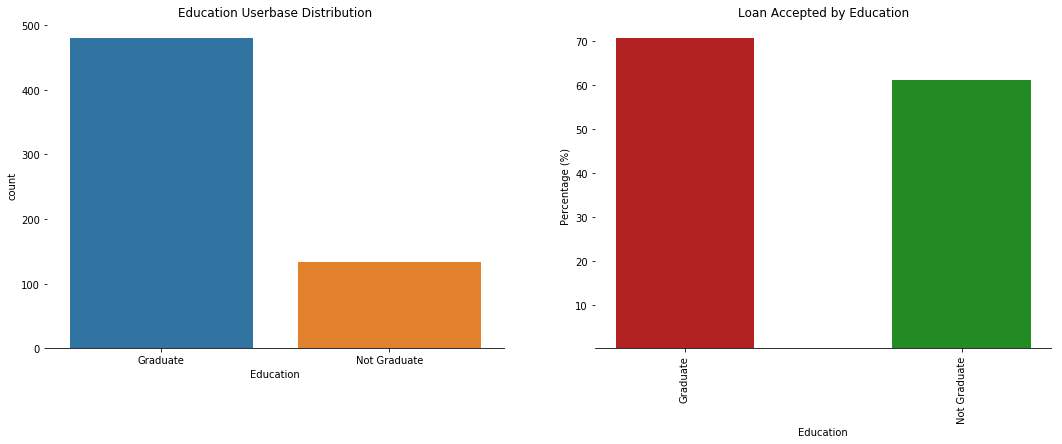

In [25]:
makebarchart(df, 'Education', 'Loan_Status')

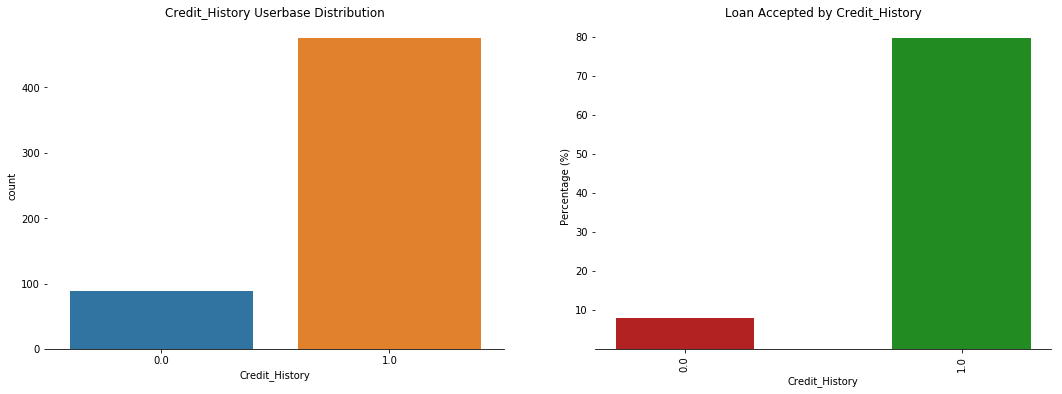

In [26]:
makebarchart(df, 'Credit_History', 'Loan_Status')

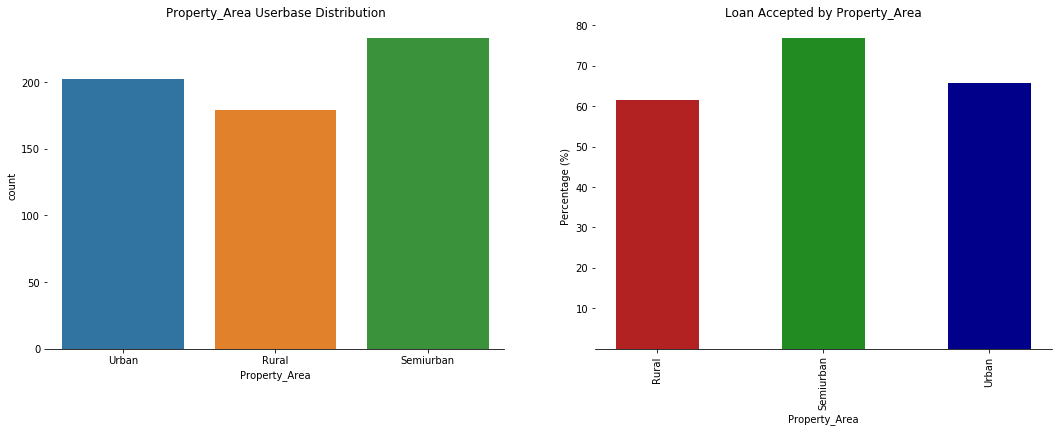

In [27]:
makebarchart(df, 'Property_Area', 'Loan_Status')

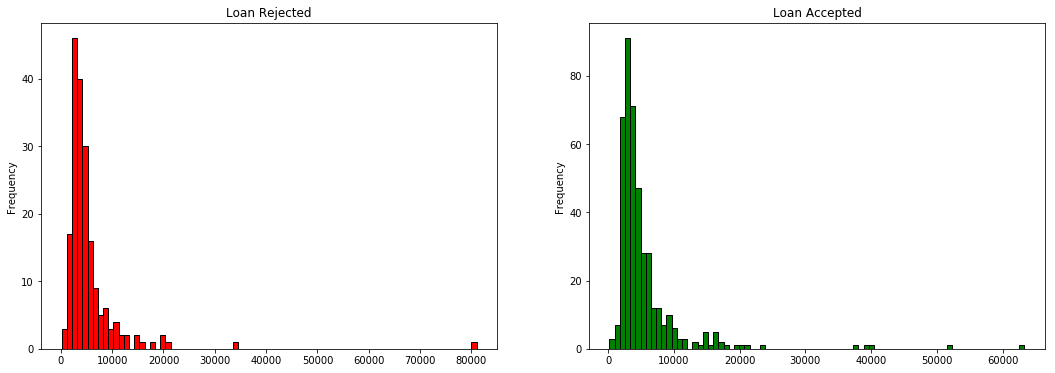

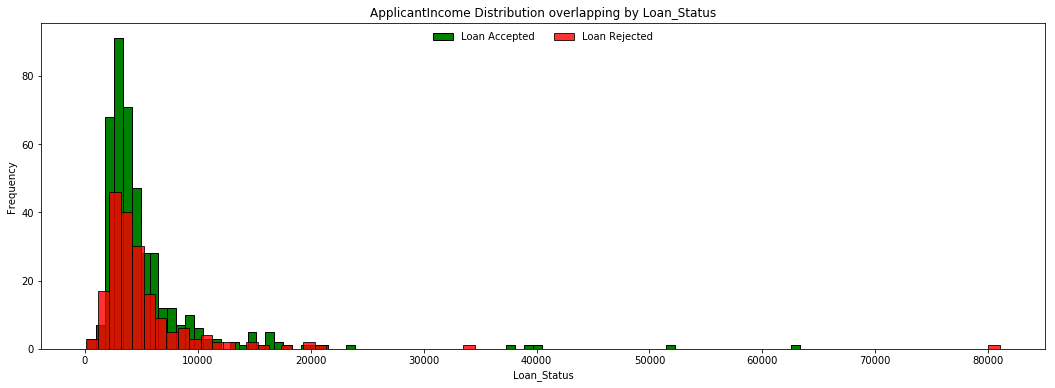

In [28]:
makehistchart(df, 'ApplicantIncome', 'Loan_Status', bins=80)

###### EDA insights

- Gender and Education does not affect Loan status. 
- On the contrary Credit History variable show a very strong influence on the chance of receiving the loan. In fact some 80% of the people with a Credit history are able to receive thei loan, agianst less than 10% of the people without.
- Property area shows a mild influence on the label.
- Applicant income seems to exert an action too.

### Data processing for Machine Learning Analysis

###### Create Feature Matrix X

In [29]:
# slice the dataframe from the first column to the last but one
feature_names = df.columns.values[:-1]
X = df[feature_names].copy() # make a copy of the original dataframe to avoid warning error
X.shape

(614, 12)

###### Label encoding of categorical variables¶¶

In [30]:
for feature in X.select_dtypes(include = ['O']).columns.values: # loop through all the feature spaces and pick only the catvars
    X[feature] = X[feature].factorize(na_sentinel=2)[0] # we encode with numeric label the catvar and assign a default value of 2 to NaN
X.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,0,0,0,0,0,0,5849,0,NaN,360.0,1.0,0
1,1,0,1,1,0,0,4583,1508,128.0,360.0,1.0,1
2,2,0,1,0,0,1,3000,0,66.0,360.0,1.0,0
3,3,0,1,0,1,0,2583,2358,120.0,360.0,1.0,0
4,4,0,0,0,0,0,6000,0,141.0,360.0,1.0,0


In [31]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
Loan_ID              614 non-null int64
Gender               614 non-null int64
Married              614 non-null int64
Dependents           614 non-null int64
Education            614 non-null int64
Self_Employed        614 non-null int64
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null int32
LoanAmount           592 non-null float64
Loan_Amount_Term     600 non-null float64
Credit_History       564 non-null float64
Property_Area        614 non-null int64
dtypes: float64(3), int32(1), int64(8)
memory usage: 55.2 KB


There are also some numeric variables that must be filled due to the presence of NaN

In [32]:
X['Credit_History'] = X['Credit_History'].factorize(na_sentinel=2)[0]

In [33]:
X.Credit_History.value_counts()

0    475
1     89
2     50
Name: Credit_History, dtype: int64

In [34]:
#Let's impute the mean value to the missing ones for both features
X['Loan_Amount_Term'].fillna(X.Loan_Amount_Term.mean(), inplace=True)
X['LoanAmount']= X['LoanAmount'].fillna(X.LoanAmount.mean())

In [35]:
#This is a caetgory we enginereed previously. Here the most sound choice to do is to fill missing values with the most frequent value
X['Dependents'] = X['Dependents'].fillna(X.Dependents.mode()[0])

In [36]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
Loan_ID              614 non-null int64
Gender               614 non-null int64
Married              614 non-null int64
Dependents           614 non-null int64
Education            614 non-null int64
Self_Employed        614 non-null int64
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null int32
LoanAmount           614 non-null float64
Loan_Amount_Term     614 non-null float64
Credit_History       614 non-null int64
Property_Area        614 non-null int64
dtypes: float64(2), int32(1), int64(9)
memory usage: 55.2 KB


Feature matrix full of numeric values only and showing no presence of missing values. Ready for manipulation

###### Create response vector y

In [37]:
y= df.Loan_Status
y.shape

(614,)

### Cross validation¶

The dataset size is very small, therefore we could easily expect a strong variance during the CV fase, i.e. the results to be severely influenced by the way we select the training set. Let's verify this 

In [38]:
# split data in train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.33)

### Model Selection

We will try now to select the best model to obtain predictions. The 1st model we try is:

###### Random Forest

In [39]:
rf = RandomForestClassifier(n_estimators=30, # to speed up process time and obtain acceptable results
                            n_jobs=-1,        # to exploit all cores
                            random_state=23,  # for reproducibility
                            oob_score=True)  # to exploit internal cross validation tool of RF classifier

In [40]:
# train the model
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
            oob_score=True, random_state=23, verbose=0, warm_start=False)

In [41]:
# calculate the accuracy of the model on training set
training_accuracy = rf.score(X_train, y_train) 
print('Accuracy of Training set = {:.4f}'.format(training_accuracy))

Accuracy of Training set = 1.0000


Training accuracy is very high, no chance of underfitting, hence we can be sure the model is no biased

In [42]:
print('Cross Validation accuracy  = {:.4f}'.format(rf.oob_score_))

Cross Validation accuracy  = 0.7664


In [43]:
# predict conversion rate on unseen data X_test
y_pred = rf.predict(X_test)
test_score = rf.score(X_test, y_test)
print('Accuracy of Testing set = {:.4f}'.format(test_score))

Accuracy of Testing set = 0.7734


Accuracy went down quite consistently to some 78%, indicating that the model is now overfitting. Before trying to come out with strategies to increase the accuracy let's check the null accuracy and classification report

In [44]:
Null_Accuracy = max(y_test.mean(), 1-y_test.mean()) 
print('Null Accuracy= {:.4f}'.format (Null_Accuracy)) # Baseline for model evaluation

Null Accuracy= 0.6453


In [45]:
print('Classification Report=\n\n',(classification_report(y_test, y_pred)))

Classification Report=

              precision    recall  f1-score   support

          0       0.80      0.49      0.60        72
          1       0.77      0.93      0.84       131

avg / total       0.78      0.77      0.76       203



Confusion Matrix:


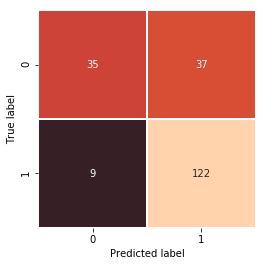

In [46]:
print('Confusion Matrix:')
matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, square=True, annot=True, vmin=8, vmax= 60, fmt='d', cbar=False, linewidths=0.2, center=True)
plt.xlabel('Predicted label')
plt.ylabel('True label');

In [47]:
#Let's calculate ROC metric
y_pred_proba = rf.predict_proba(X_test)[:,1] # model predicted probability of class 1
rf_roc_auc = roc_auc_score(y_test, y_pred_proba)
print('Random Forest AUC Score =', round(rf_roc_auc,4))

Random Forest AUC Score = 0.7934


As foresaw accuracy prediction rate on unseen data decreased considerably, becasue the model parameters strongly adapted to the training set. A possible solution to limit this effect might be to cross validate the entire dataset, instead of just splitting it into two block. 

Let's use the K-fold cross validation module selecting 10 folders and trying to optimize accuracy as a metric.

###  K-fold Cross validation¶


In [48]:
cv = 10
scores = cross_val_score(rf, X, y, cv=cv, scoring='accuracy')

In [49]:
for i, score in zip(list(range(1,cv+1)),scores): # loop trough each of the folders get the score
        print("Score in folder {} is:{}".format(i, score)) 

Score in folder 1 is:0.47619047619047616
Score in folder 2 is:0.7936507936507936
Score in folder 3 is:0.6885245901639344
Score in folder 4 is:0.7377049180327869
Score in folder 5 is:0.7704918032786885
Score in folder 6 is:0.8032786885245902
Score in folder 7 is:0.819672131147541
Score in folder 8 is:0.8524590163934426
Score in folder 9 is:0.7540983606557377
Score in folder 10 is:0.7868852459016393


In [50]:
print('Accuracy of {}-fold Cross Validation is: {:.4f} '.format(cv,(scores.mean())))

Accuracy of 10-fold Cross Validation is: 0.7483 


The mean score accuracy of the this 10-fold CV we performed did not improved, in fact it slightly diminished. 
We can exclude then that overfitting is derived from data variance. Let's investigate some other alternatives, as for example the model needs some parameter tuning to reduce overfitting and therefore improve accuracy.

We will try to optimize the usual most important parameters of Random Forest (nr. of trees, max features available at each split, minimum nr. of samples in leafs. We will approach the problem using a customizing grid search, manually testing  for each parameter a list of values we expect to be productive. 

### Hyperparameters

30 Trees
Accuracy = 0.773

50 Trees
Accuracy = 0.793

100 Trees
Accuracy = 0.773

200 Trees
Accuracy = 0.788

500 Trees
Accuracy = 0.788

1000 Trees
Accuracy = 0.783

2000 Trees
Accuracy = 0.788



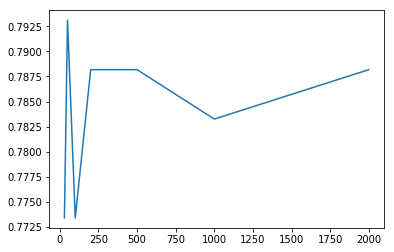

In [51]:
results =[]
n_estimators_options = [30,50,100,200,500,1000,2000]
for trees in n_estimators_options:
    model = RandomForestClassifier(trees, oob_score=True, random_state=23, n_jobs=-1 )
    model.fit(X_train, y_train)
    print( trees, 'Trees')
    score = model.score(X_test, y_test)
    print('Accuracy =', round(score,3))
    results.append(score)
    print('')
pd.Series(results, n_estimators_options).plot();

The optimal number of trees appear to be 50. Then we set this value for this parameter and test max_features

auto max_features
Accuracy = 0.793

sqrt max_features
Accuracy = 0.793

log2 max_features
Accuracy = 0.793

0.9 max_features
Accuracy = 0.803

0.8 max_features
Accuracy = 0.788



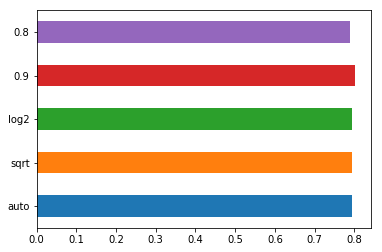

In [52]:
results =[]
max_features_options = ['auto', 'sqrt', 'log2', 0.9, 0.8]
for max_features in max_features_options:
    model = RandomForestClassifier(50, max_features=max_features, oob_score=True, random_state=42, n_jobs=-1 )
    model.fit(X_train, y_train)
    print( max_features, 'max_features')
    score= model.score(X_test, y_test)
    print('Accuracy =', round(score,3))
    results.append(score)
    print('')
pd.Series(results, max_features_options).plot(kind='barh');

The optimal value for this parameter appears to be equal to 0.9

1 min_samples_leaf
Accuracy = 0.803

2 min_samples_leaf
Accuracy = 0.798

3 min_samples_leaf
Accuracy = 0.803

4 min_samples_leaf
Accuracy = 0.808

5 min_samples_leaf
Accuracy = 0.803

6 min_samples_leaf
Accuracy = 0.798

7 min_samples_leaf
Accuracy = 0.803

8 min_samples_leaf
Accuracy = 0.798

9 min_samples_leaf
Accuracy = 0.798

10 min_samples_leaf
Accuracy = 0.798



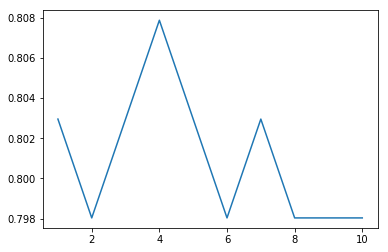

In [53]:
results =[]
min_samples_leaf_options = np.arange(1,11)
for min_samples_leaf in min_samples_leaf_options:
    model = RandomForestClassifier(50, max_features=0.9, min_samples_leaf= min_samples_leaf, oob_score=True, random_state=42, n_jobs=-1 )
    model.fit(X_train, y_train)
    print(min_samples_leaf, 'min_samples_leaf')
    score = model.score(X_test,y_test)
    print('Accuracy =', round(score,3))
    results.append(score)
    print('')
pd.Series(results, min_samples_leaf_options).plot();

Apparently the best value for this parmeter is set to four. Then we re-train the model using this best configuration we manually  came up with and we re-evaluate the RF model tuned. We will use the same train/test split we used, in light of the fact that  k-fold CV did not delivered any improvements.

In [54]:
rf = RandomForestClassifier(n_estimators=50, 
                            n_jobs=-1,
                            max_features=0.9,
                            random_state=23,  
                            min_samples_leaf=4)  

In [55]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.9, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=23, verbose=0, warm_start=False)

In [56]:
# calculate the accuracy of the model on training set
training_accuracy = rf.score(X_train, y_train) 
print('Accuracy of Training set = {:.4f}'.format(training_accuracy))

Accuracy of Training set = 0.8856


Not surprisingly the tune model training accuracy reduced a little bit, but that is not a big issue, considering that the main metric we are after is Test Accuracy. Let's check its variation

In [57]:
# predict conversion rate on unseen data X_test
y_pred = rf.predict(X_test)
test_score = rf.score(X_test, y_test)
print('Testing Accuracy =', test_score)

Testing Accuracy = 0.7931034482758621


As expected Testing Accuracy for this tuned model went up, when compared with the previous value (0.773), but not as we would have hoped. Apparently this is the best that this model can do with these features set.

As a side exercise and to have visualition of the actual performaces we can plot the learning curves and check the trend of testing and training accuracy. 

### Plotting Learning Curves

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(20,5))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training set sizes")
    plt.ylabel("Error")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_error_mean = 1-np.mean(train_scores, axis=1)
    test_error_mean = 1- np.mean(test_scores, axis=1)
    plt.grid()
    plt.plot(train_sizes, train_error_mean, 'o-', color="r",
             label="Training error")
    plt.plot(train_sizes, test_error_mean, 'o-', color="g",
             label="Cross-validation error")

    plt.legend(loc="best")
    return plt

In [ ]:
title = "Learning Curves (Random Forest)"
plot_learning_curve(rf, title, X, y, ylim=(0.01, 0.5), cv=None, n_jobs=-1);

The plot confirms that as the size of the training set increases the testing accuracy goes down, but with this reduced set of observations this is the best the model can do. Very likely if we could fed the model with some more observations, the model would benefit, therefore this is a case where gathering more observations is an objective to pursue.

Last tool in our arsenal, to try and improve this model performance, relies on trying to simplify it, considering that the model is overfitting at this moment and therefore is adpating to much to the complexity.Or in other words the model is not able to catch the signals in the data. 

The easy way to simplify a model is to reduce the number of features to the most important ones. The first step in this strategy is to pick just the most important features and use them to train the model, dropping the less relevant ones.

This is easy done trough the feature importances attribute made it available with *feature_importances_* 

### Feature importances

In [ ]:
#zip the array and sort it
for feature in sorted(list(zip(rf.feature_importances_, X)), reverse=True):
    print(feature)

In [ ]:
# Chart a visual representation
feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values().plot(kind='barh', figsize=(10,5))
plt.title('Feature Importances'), plt.xlabel('% of importance');

In [ ]:
# create a list of less relevant variables to be dropped in the model
irrelevant_features = ['Education','Self_Employed', 'Gender', 'Dependents','Married', 'Loan_Amount_Term', 'Loan_ID']

In [ ]:
X_new = X.drop(irrelevant_features, axis=1) # Create the new dataset we want to adopt
X_new.head()

In [ ]:
# split data in train and test set
X_new_train, X_new_test, y_train, y_test = train_test_split(X_new, y, random_state=42, test_size=0.33)

In [ ]:
#let's use the same tune model we have identified as the best one
rf = RandomForestClassifier(n_estimators=50, 
                            n_jobs=-1, 
                            max_features=0.9,
                            random_state=23,  
                            min_samples_leaf=4)  

In [ ]:
#train the model with these reduced number of features
rf.fit(X_new_train, y_train)

In [ ]:
# calculate the accuracy of the model on training set
training_accuracy = rf.score(X_new_train, y_train) 
print('Accuracy of Training set = {:.4f}'.format(training_accuracy))

In [ ]:
print('New Testing Accuracy after feature reduction is = {:.4f}'.format(rf.score(X_new_test, y_test)))

Unfortunately no improvement has been shown by this feature reduction, therefore we can conclude that some 80% accuracy is the best we can do with Random Forest model using these dataset.

Let's try another tree-based model as GBT, to verify if is a better fit for our problem

### GRADIENT BOOSTING REGRESSION

In [ ]:
est = GradientBoostingClassifier(n_estimators=100, max_depth=2, 
                                 learning_rate=0.1,
                                  min_samples_leaf=4, 
                                  random_state=0)

In [ ]:
#fit the data
est.fit(X_new_train,y_train)

In [ ]:
est.score(X_new_train, y_train)

In [ ]:
est.score(X_new_test, y_test)

Once again a very modest increase in the performance, but not a substantial one.

Just to reinforce the concept of feature importance let's exploit the partial dependence plot tool made available by this type of classifier.

In [ ]:
fig, axs = plot_partial_dependence(est, X_new_train, features=X_new_train.columns.values, feature_names=X_new.columns.values, 
                                   n_cols=2,figsize=(20,10) )

Again Credit History is the key here, and applicant income and Loan amount, but also Property Area play some role in the final decision to grant or reject a loan.

We tried so far tree-base model. We might wonder if some other type of algorithms might provide a better accuracy.
Let's try some other wide used ones, as, for instance, the well known Logisti Regression.

### Logistic Regression

One important difference of this model when compared with tree-based models is that the latters does not care about indipendent variables linearity, because at each split the model will try to optimize the chosen metric (default Gini index) and neglect two or more variables that carry the same piece of information. 

Regression models' results like Logistic Regression, on the contary, are heavily affected by these relactions. Therefore to improve accuracy is better to perform a correlation analysis of the features and analize if they are correlated among themselves, in order to drop the ones that in fact are. 

Seaborn library provides with an easy to use function to features collinearity.

In [ ]:
sns.heatmap(X.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) 
fig=plt.gcf()
fig.set_size_inches(10,8)

The diagram above shows unequivocably a very strong dependence between 'ApplicantIncome' and 'LoanAmount' variables ( with a correlation coefficient of + 0.57). And this is a match with intuitive experience of people with higher income applicating for higher loan amounts. 

To proceed with the analysis of a Logistic Regression model, then let's select the already optimized model with the most relevant features and from this one, let's drop one of the two variables we just mentioned (ex. Loan Amount).

In [ ]:
X_log = X_new.drop('LoanAmount', 1); X_log.head()

In [ ]:
#let' split in train/test set this dataset
X_log_train, X_log_test, y_train, y_test = train_test_split(X,y, test_size=.3)

In [ ]:
lr= LogisticRegression(C=2) # instantiate the classifier with a Regularization parameter C equal to 2
lr.fit(X_log_train, y_train)
print('Train Acc:', lr.score(X_log_train, y_train))
print('Test Acc:', lr.score(X_log_test, y_test))

To accelerate convergence of the algorithm is better to standardize the data to homogenize features's range, transforming them in an equivalent dataset with mean= 0 and σ=1

In [ ]:
from sklearn.preprocessing import StandardScaler # import classifier
standard_scaler = StandardScaler() # instantiate
X_train_scaled = standard_scaler.fit_transform(X_log_train) # scale the training set
X_test_scaled = standard_scaler.fit_transform(X_log_test) # scale the testing set
lr.fit(X_train_scaled, y_train) # train the classifier
print('Train Accuracy of regularized Logistic Regression:', lr.score(X_train_scaled, y_train)) 
print('Test Accuracy of regularized Logistic Regression:', lr.score(X_test_scaled, y_test))

 **test set performance** achieved is much worse than Random Forest or Gradient Boosting

### Naive Bayes

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.33)

###### Multinomial Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB().fit(X_train, y_train)
print('Multinomial NB accuracy is:{:.3f}'.format(mnb.score(X_test, y_test)))

######  Gaussian Naive Bayes  

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB().fit(X_train, y_train)
print('Gaussian NB accuracy is:{:.3f}'.format(gnb.score(X_test, y_test)))

###### Bernoulli Naive Bayes

In [ ]:
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB().fit(X_train, y_train)
print('Bernoulli NB accuracy is:{:.3f}'.format(bnb.score(X_test, y_test)))

# Conclusions

We investigated the chance to automate the process of eligibility of a loan to some customers, adopting a Supervised Machine Learning approach, testing some widely used algorithm on an existing small dataset.

The most predicted class is Loan_status = 'Y', which basically implies that loan was granted to the requester, with a percentage hovering around 70%. This, thus, represented our lower limit to select a good classifier. Anything lower than that would be worst than just always predict a class of 'Y'.

We tested **Random Forest** and our best model was able to predict correctly **around 80%** of the data, when tested on unseen data. 
The final result did not dramatically change when evaluating other tree-based model's performances like **Gradient Boosting**.

**Logistic Regression** performance was very bad. **Naive Bayes with Bernoulli distribution** performed a bit worse. 

The models, then, showed a mild improvement on null-accuracy, but nothing exceptional. Nonetheless this result was to be expected, due to the size of the dataset, comprising just **614 observations**.

Surely increasing dataset's size will allow to improve accuracy reducing overfitting process.

The analisys highlighted that, by far, the most correlated variable to the label is the Credit History.